# Extracting coastlines from Global Coastal Transect System GCTS and Satellite Derived Shorelines System SDSS

Run the first few cells to load required functions and jump to the section you're interested in afterwards. 

In [8]:
import sys

# sys.path.insert(0, "..\src")
sys.path.insert(0, "../src")

import dask
# NOTE: query planning is not implemented in dask_geopandas yet, so we have to set 
# it to False before we do any dask_geopandas import 
dask.config.set({"dataframe.query-planning": False})

from coastlines4shorelines.utils import transect_origins_to_coastline,retrieve_transects_by_roi,shoreline_intersections_to_coastline,filter_sp

import logging
import os
import pathlib


from dask.dataframe.utils import make_meta

import dask_geopandas
import duckdb
import geopandas as gpd
import hvplot.pandas
import pandas as pd
import pystac
import shapely
from dotenv import load_dotenv
from ipyleaflet import Map, basemaps

from coastmonitor.geo.geometries import geo_bbox

load_dotenv(override=True)

sas_token = os.getenv("AZURE_STORAGE_SAS_TOKEN")
account_name = os.getenv("AZURE_STORAGE_ACCOUNT_NAME")
storage_options = {"account_name": account_name, "credential": sas_token}

logging.getLogger("azure").setLevel(logging.WARNING)

## Load from STAC catalog

Load the transects from our CoCliCo STAC catalog. 

In [9]:
coclico_catalog = pystac.Catalog.from_file(
    "https://coclico.blob.core.windows.net/stac/v1/catalog.json"
)

In [10]:
coclico_catalog

<Catalog id=coclico-catalog>

In [11]:
list(coclico_catalog.get_all_collections())

[<Collection id=ssl>,
 <Collection id=wef>,
 <Collection id=eesl>,
 <Collection id=floodmaps>,
 <Collection id=sc>,
 <Collection id=cbca>,
 <Collection id=cfr>,
 <Collection id=smd>,
 <Collection id=cisi>,
 <Collection id=slp5>,
 <Collection id=slp6>,
 <Collection id=slp6_pilot>,
 <Collection id=coastal-mask>,
 <Collection id=shorelinemonitor-shorelines>,
 <Collection id=overture-building-footprints>,
 <Collection id=deltares-delta-dtm>,
 <Collection id=gcts>,
 <Collection id=gctr>,
 <Collection id=pp>,
 <Collection id=ceed>,
 <Collection id=cfhp>,
 <Collection id=slp>,
 <Collection id=shorelinemonitor-raw-series>]

In [12]:
gcts = coclico_catalog.get_child("gcts")
gcts

<Collection id=gcts>

### Define a region of interest (ROI) based on a kml file

In [13]:
import fiona

fiona.drvsupport.supported_drivers["KML"] = "rw"
kml_fp = pathlib.Path(r"d:\FHICS\ShorelineS\ROIs\North_Carolina_Virginia.kml")
roi = gpd.read_file(kml_fp, driver="KML")

### Get all transects for this region of interest

In [14]:
transects_roi = retrieve_transects_by_roi(roi, storage_options=storage_options)

In [15]:
transects_roi.head()

,tr_name,lon,lat,bearing,geometry,coastline_is_closed,coastline_length,utm_crs,bbox,quadkey,isoCountryCodeAlpha2,admin_level_1_name,isoSubCountryCode,admin_level_2_name,coastline_name,coastline_id,segment_id,transect_id
1516690,cl13508s02tr00000057,-83.999512,30.104334,146.738235,"LINESTRING (-84.00543 30.11174, -83.99360 30.0...",False,4374810,32617,"{'xmax': -83.99360027836704, 'xmin': -84.00542...",032021022100,US,United States,US-FL,Florida,cl13508s02,13508,2,57
1516683,cl13508s02tr00000157,-83.998611,30.104618,264.559326,"LINESTRING (-83.98832 30.10571, -84.00891 30.1...",False,4374810,32617,"{'xmax': -83.98832044967999, 'xmin': -84.00890...",032021022100,US,United States,US-FL,Florida,cl13508s02,13508,2,157
1516714,cl13508s02tr00000257,-83.998512,30.103722,266.486176,"LINESTRING (-83.98818 30.10451, -84.00884 30.1...",False,4374810,32617,"{'xmax': -83.98818426810105, 'xmin': -84.00884...",032021022100,US,United States,US-FL,Florida,cl13508s02,13508,2,257
1516716,cl13508s02tr00000357,-83.998421,30.102823,266.244781,"LINESTRING (-83.98810 30.10365, -84.00875 30.1...",False,4374810,32617,"{'xmax': -83.98809653195572, 'xmin': -84.00874...",032021022100,US,United States,US-FL,Florida,cl13508s02,13508,2,357
1516736,cl13508s02tr00000457,-83.998329,30.101925,267.026794,"LINESTRING (-83.98799 30.10263, -84.00866 30.1...",False,4374810,32617,"{'xmax': -83.98799102439123, 'xmin': -84.00866...",032021022100,US,United States,US-FL,Florida,cl13508s02,13508,2,457


In [16]:
list(transects_roi)

['tr_name',
 'lon',
 'lat',
 'bearing',
 'geometry',
 'coastline_is_closed',
 'coastline_length',
 'utm_crs',
 'bbox',
 'quadkey',
 'isoCountryCodeAlpha2',
 'admin_level_1_name',
 'isoSubCountryCode',
 'admin_level_2_name',
 'coastline_name',
 'coastline_id',
 'segment_id',
 'transect_id']

### Apply transect_origins_to_coastline and explode to get one LineString per row

In [17]:
coastline = (
    transects_roi.groupby("coastline_id")
    .apply(transect_origins_to_coastline)
    .explode()
    .reset_index(name="geometry")
    .drop(columns=["level_1"])
)
coastline.head()

C:\Users\dro\AppData\Local\Temp\ipykernel_17536\4286755964.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(transect_origins_to_coastline)


,coastline_id,geometry
0,13508,LINESTRING (-83.99951171875 30.104333877563477...
1,13508,LINESTRING (-77.99943542480469 33.964660644531...
2,13564,LINESTRING (-77.19999694824219 34.642490386962...
3,13567,LINESTRING (-77.40233612060547 34.511249542236...
4,13570,LINESTRING (-77.81329345703125 34.211761474609...


In [18]:
coastline = gpd.GeoDataFrame(coastline, crs=4326)
coastline = gpd.overlay(coastline, roi[["geometry"]]).explode(index_parts=False)
coastline.head()

,coastline_id,geometry
0,13508,"LINESTRING Z (-78.54092 33.85170 0.00000, -78...."
1,13508,"LINESTRING Z (-77.90807 34.05511 0.00000, -77...."
1,13508,"LINESTRING Z (-77.56159 34.43149 0.00000, -77...."
1,13508,"LINESTRING Z (-77.46359 34.48776 0.00000, -77...."
1,13508,"LINESTRING Z (-77.67541 34.35065 0.00000, -77...."


### Explore the ROI polygon and the cleaned up base coastline

In [19]:
m = roi.explore()
gpd.GeoDataFrame(coastline, crs=4326).explore(color="red", m=m)

### Load ShorelineMonitor SDS series 

In [20]:
sdss = dask_geopandas.read_parquet(
    "az://shorelinemonitor-raw-series/release/2024-04-15/sp_NC.parquet",
    storage_options=storage_options,
).compute()
sdss = sdss.assign(time=pd.to_datetime(sdss.time).dt.strftime("%Y-%m-%d"))

### Implement the filtering function to raw time series

In [21]:
sdss_clean = filter_sp(sdss)
list(sdss_clean)

['time', 'tr_name', 'lon', 'lat', 'shoreline_position', 'geometry']

### Sort on transect name and extract transect name into coastline_id, segment_id and transect_id

In [22]:
    sdss = sdss_clean.sort_values("tr_name")
    sdss[["coastline_id", "segment_id", "transect_id"]] = (
        sdss.tr_name.str.extract(r"cl(\d+)s(\d+)tr(\d+)")
    )
    sdss = sdss.astype(
        {"coastline_id": int, "segment_id": int, "transect_id": int}
    )
    sdss.head()

,time,tr_name,lon,lat,shoreline_position,geometry,coastline_id,segment_id,transect_id
0,1984-01-01,cl13508s05tr02478857,-75.884092,36.485646,0.000000,POINT (-75.88409 36.48565),13508,5,2478857
19,2005-01-01,cl13508s05tr02478857,-75.883928,36.485712,-16.470432,POINT (-75.88393 36.48571),13508,5,2478857
20,2006-01-01,cl13508s05tr02478857,-75.883943,36.485706,-14.962722,POINT (-75.88394 36.48571),13508,5,2478857
21,2007-01-01,cl13508s05tr02478857,-75.884148,36.485624,5.547069,POINT (-75.88415 36.48562),13508,5,2478857
22,2008-01-01,cl13508s05tr02478857,-75.883942,36.485706,-15.043074,POINT (-75.88394 36.48571),13508,5,2478857


### Create subsets of sdss for 2010 and 2020

In [23]:
import pandas as pd
# Ensure your time column is in datetime format
sdss['time'] = pd.to_datetime(sdss['time'])

# Define the specific date
specific_date = pd.Timestamp('2010-01-01')

# Filter the GeoDataFrame
sdss_2010 = sdss.loc[sdss['time'] == specific_date]
m=sdss_2010.geometry.explore()

In [24]:
sdss_2010

,time,tr_name,lon,lat,shoreline_position,geometry,coastline_id,segment_id,transect_id
24,2010-01-01,cl13508s05tr02478857,-75.883934,36.485709,-15.822546,POINT (-75.88393 36.48571),13508,5,2478857
60,2010-01-01,cl13508s05tr02479057,-75.888493,36.481505,-1.989754,POINT (-75.88849 36.48151),13508,5,2479057
95,2010-01-01,cl13508s05tr02479157,-75.889056,36.480556,-13.044221,POINT (-75.88906 36.48056),13508,5,2479157
131,2010-01-01,cl13508s05tr02479257,-75.888925,36.479661,-12.823608,POINT (-75.88892 36.47966),13508,5,2479257
186,2010-01-01,cl13508s05tr02479457,-75.889836,36.477854,-5.407087,POINT (-75.88984 36.47785),13508,5,2479457
...,...,...,...,...,...,...,...,...,...
222105,2010-01-01,cl13935s00tr00025349,-76.643510,34.686461,-26.736725,POINT (-76.64351 34.68646),13935,0,25349
222134,2010-01-01,cl13935s00tr00025449,-76.644612,34.686512,-35.233979,POINT (-76.64461 34.68651),13935,0,25449
222163,2010-01-01,cl13935s00tr00025549,-76.645709,34.686520,-8.232568,POINT (-76.64571 34.68652),13935,0,25549
222192,2010-01-01,cl13935s00tr00025649,-76.646800,34.686574,11.998174,POINT (-76.64680 34.68657),13935,0,25649


### Try a merge of the OSM smoothed coastline and the points for specific years from sdss 

In [25]:
merge_2010=pd.merge(transects_roi[["tr_name","lon","lat"]],sdss_2010,how="left",on="tr_name")

In [26]:
merge=pd.merge(transects_roi[["tr_name","lon","lat"]],sdss,how="left",on="tr_name")

In [27]:
merge

,tr_name,lon_x,lat_x,time,lon_y,lat_y,shoreline_position,geometry,coastline_id,segment_id,transect_id
0,cl13508s02tr00000057,-83.999512,30.104334,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
1,cl13508s02tr00000157,-83.998611,30.104618,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
2,cl13508s02tr00000257,-83.998512,30.103722,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
3,cl13508s02tr00000357,-83.998421,30.102823,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
4,cl13508s02tr00000457,-83.998329,30.101925,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
357849,cl13969s00tr00005348,-77.968452,33.896950,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
357850,cl13969s00tr00005448,-77.968651,33.897831,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
357851,cl13969s00tr00005548,-77.969139,33.898605,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN
357852,cl13969s00tr00005648,-77.970139,33.898811,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN


In [95]:
import netCDF4

gdf = gpd.GeoDataFrame(merge)
gdf['time'] = pd.to_datetime(gdf['time'])

# Pivot the data
lon_pivot = gdf.pivot(index='time', columns='tr_name', values='lon_y')
lat_pivot = gdf.pivot(index='time', columns='tr_name', values='lat_y')

# Convert the pivot tables to xarray DataArray
lon_xr = xr.DataArray(lon_pivot)
lat_xr = xr.DataArray(lat_pivot)

# Create a Dataset from the DataArrays
ds = xr.Dataset({'lon': lon_xr, 'lat': lat_xr})
ds.to_netcdf('test.nc')
print(ds)

<xarray.Dataset> Size: 90MB
Dimensions:  (time: 39, tr_name: 141853)
Coordinates:
  * time     (time) datetime64[ns] 312B NaT 1984-01-01 ... 2020-01-01 2021-01-01
  * tr_name  (tr_name) object 1MB 'cl13508s02tr00000057' ... 'cl13969s00tr000...
Data variables:
    lon      (time, tr_name) float64 44MB nan nan nan nan ... nan nan nan nan
    lat      (time, tr_name) float64 44MB nan nan nan nan ... nan nan nan nan


C:\Users\dro\AppData\Local\Temp\ipykernel_17536\2143525246.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(ds.time))
C:\Users\dro\AppData\Local\Temp\ipykernel_17536\2143525246.py:20: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_year['geometry'] = gpd.points_from_xy(gdf_year.lon, gdf_year.lat)
C:\Users\dro\AppData\Local\Temp\ipykernel_17536\2143525246.py:20: FutureWarning: You are adding a colu

(35.0, 36.0)

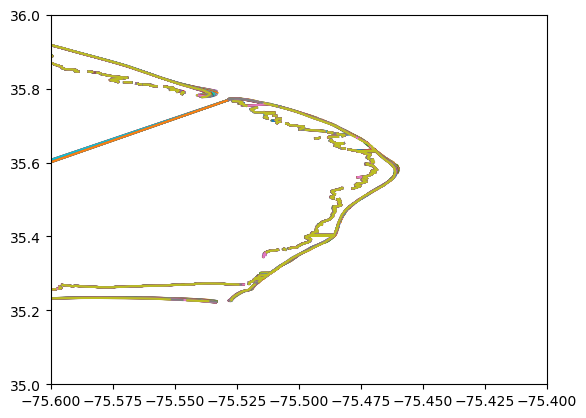

In [93]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# Define the colormap
cmap = plt.cm.get_cmap('rainbow', len(ds.time))

# Extract the unique years
years = pd.to_datetime(ds.time.values)
unique_years = sorted(set(years))

for i, year in enumerate(unique_years):
    # Select data for the specific year
    year_data = ds.sel(time=year)
    plt.plot(year_data.lon,year_data.lat)
    gdf_year=gpd.GeoDataFrame({"lon":year_data.lon,"lat":year_data.lat})
    # Convert lon and lat to geometry
    gdf_year['geometry'] = gpd.points_from_xy(gdf_year.lon, gdf_year.lat)
    gdf_year = gdf_year.set_crs(epsg=4326)  # WGS 84

plt.xlim(-75.6, -75.4)
plt.ylim(35,36
         )
    

In [87]:
gdf_year.explore()

In [54]:
g

In [55]:
unique_years

[nan,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0]

In [42]:
years = pd.to_datetime(ds.time.values).year.round(0)
years

Index([   nan, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0,
       1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0,
       2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0,
       2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0,
       2019.0, 2020.0, 2021.0],
      dtype='float64')

In [ ]:
times = merge["time"].unique()
indx = times.argsort()
times[indx]

<DatetimeArray>
['1984-01-01 00:00:00', '1985-01-01 00:00:00', '1986-01-01 00:00:00',
 '1987-01-01 00:00:00', '1988-01-01 00:00:00', '1989-01-01 00:00:00',
 '1990-01-01 00:00:00', '1991-01-01 00:00:00', '1992-01-01 00:00:00',
 '1993-01-01 00:00:00', '1994-01-01 00:00:00', '1995-01-01 00:00:00',
 '1996-01-01 00:00:00', '1997-01-01 00:00:00', '1998-01-01 00:00:00',
 '1999-01-01 00:00:00', '2000-01-01 00:00:00', '2001-01-01 00:00:00',
 '2002-01-01 00:00:00', '2003-01-01 00:00:00', '2004-01-01 00:00:00',
 '2005-01-01 00:00:00', '2006-01-01 00:00:00', '2007-01-01 00:00:00',
 '2008-01-01 00:00:00', '2009-01-01 00:00:00', '2010-01-01 00:00:00',
 '2011-01-01 00:00:00', '2012-01-01 00:00:00', '2013-01-01 00:00:00',
 '2014-01-01 00:00:00', '2015-01-01 00:00:00', '2016-01-01 00:00:00',
 '2017-01-01 00:00:00', '2018-01-01 00:00:00', '2019-01-01 00:00:00',
 '2020-01-01 00:00:00', '2021-01-01 00:00:00',                 'NaT']
Length: 39, dtype: datetime64[ns]

In [36]:
ds.time

<xarray.DataArray 'time' (time: 39)> Size: 312B
array([                          'NaT', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1986-01-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '1988-01-01T00:00:00.000000000',
       '1989-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1994-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1997-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1999-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2004-01-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2007-01-01T00:00:00.000000000', '2008-01-01T00:00:00.000000000',
       '2009-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2011-01-01T00:00:00.000000000', '2012-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 312B NaT 1984-01-01 ... 2020-01-01 2021-01-01

In [ ]:
import xarray as xr

xrds =merge_2010.to_xarray()

time = pd.date_range(start="2000", end="2022", freq="YS")
xrds_t = xrds.expand_dims(timey=time)
xrds_t.dims

FrozenMappingWarningOnValuesAccess({'timey': 23, 'index': 141853})

In [ ]:
xrds_t

<xarray.Dataset> Size: 262MB
Dimensions:             (timey: 23, index: 141853)
Coordinates:
  * timey               (timey) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
  * index               (index) int64 1MB 0 1 2 3 ... 141850 141851 141852
Data variables:
    tr_name             (timey, index) object 26MB 'cl13508s02tr00000057' ......
    lon_x               (timey, index) float32 13MB -84.0 -84.0 ... -77.97
    lat_x               (timey, index) float32 13MB 30.1 30.1 30.1 ... 33.9 33.9
    time                (timey, index) datetime64[ns] 26MB NaT NaT ... NaT NaT
    lon_y               (timey, index) float64 26MB nan nan nan ... nan nan nan
    lat_y               (timey, index) float64 26MB nan nan nan ... nan nan nan
    shoreline_position  (timey, index) float64 26MB nan nan nan ... nan nan nan
    geometry            (timey, index) object 26MB None None None ... None None
    coastline_id        (timey, index) float64 26MB nan nan nan ... nan nan nan
    segment_id          (timey, index) float64 26MB nan nan nan ... nan nan nan
    transect_id         (timey, index) float64 26MB nan nan nan ... nan nan nan

(34.0, 37.0)

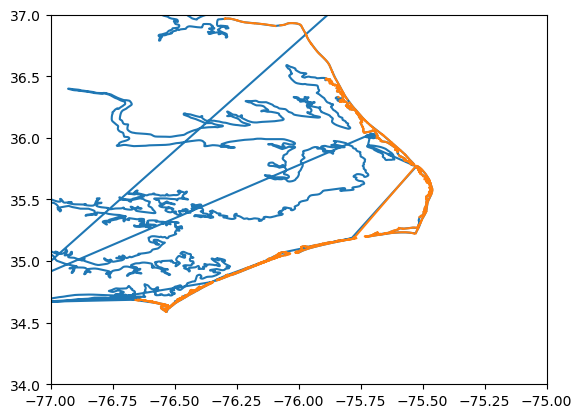

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xrds["lon_x"],xrds["lat_x"],xrds["lon_y"],xrds["lat_y"])
plt.xlim([-77,-75])
plt.ylim([34,37])

In [ ]:
xrds.dims

FrozenMappingWarningOnValuesAccess({'index': 141853})

In [ ]:
c_2010=gpd.GeoDataFrame(merge_2010,geometry=gpd.GeoSeries.from_xy(merge_2010.lon_y,merge_2010.lat_y,crs=4326))
c_2010=c_2010.rename(columns={"lon_y":"lon","lat_y":"lat"})
coast_2010 = shoreline_intersections_to_coastline(c_2010)
coast_2010
gpd.GeoDataFrame(geometry=coast_2010,crs=4326).explore()

### Show both datasets; notice they are points

In [ ]:
import pandas as pd
# Ensure your time column is in datetime format
sdss['time'] = pd.to_datetime(sdss['time'])

# Define the specific date
specific_date = pd.Timestamp('2020-01-01')

# Filter the GeoDataFrame
sdss_2020 = sdss.loc[sdss['time'] == specific_date]
sdss_2020.geometry.explore(color="red", m=m)

In [ ]:
import pandas as pd
# Ensure your time column is in datetime format
sdss['time'] = pd.to_datetime(sdss['time'])

# Define the specific date
specific_date = pd.Timestamp('2022-01-01')

# Filter the GeoDataFrame
sdss_2022 = sdss.loc[sdss['time'] == specific_date]
sdss_2022.geometry.explore(color="green", m=m)

In [ ]:
#list(sdss_2010)

### Now connect the dots

In [ ]:
coastline_2010 = shoreline_intersections_to_coastline(sdss_2010)
coastline_2020 = shoreline_intersections_to_coastline(sdss_2020)
#list(coastline_2020)

### Turn the LineStrings into a GeoDataFrame

In [ ]:
coastline_2010 = gpd.GeoDataFrame(geometry=coastline_2010,crs=4326)
coastline_2020 = gpd.GeoDataFrame(geometry=coastline_2020,crs=4326)

### Now explore both coastlines

In [ ]:
m = coastline_2010.explore()
coastline_2020.explore(color="red", columnn="time", m=m)

In [ ]:
import geopandas as gpd
import pandas as pd
import xarray as xr

# Assuming gdf is your GeoPandas GeoDataFrame
# Sample data creation (replace this with your actual GeoDataFrame)
data = {
    'transect_name': ['A', 'B', 'A', 'B'],
    'lon': [-123.3656, -123.3657, -123.3656, -123.3657],
    'lat': [48.4284, 48.4285, 48.4284, 48.4285],
    'time': ['2021-01-01', '2021-01-01', '2021-01-02', '2021-01-02']
}
gdf = gpd.GeoDataFrame(data)
gdf['time'] = pd.to_datetime(gdf['time'])

# Pivot the data
lon_pivot = gdf.pivot(index='time', columns='transect_name', values='lon')
lat_pivot = gdf.pivot(index='time', columns='transect_name', values='lat')

# Convert the pivot tables to xarray DataArray
lon_xr = xr.DataArray(lon_pivot)
lat_xr = xr.DataArray(lat_pivot)

# Create a Dataset from the DataArrays
ds = xr.Dataset({'lon': lon_xr, 'lat': lat_xr})

print(ds)

<xarray.Dataset> Size: 96B
Dimensions:        (time: 2, transect_name: 2)
Coordinates:
  * time           (time) datetime64[ns] 16B 2021-01-01 2021-01-02
  * transect_name  (transect_name) object 16B 'A' 'B'
Data variables:
    lon            (time, transect_name) float64 32B -123.4 -123.4 -123.4 -123.4
    lat            (time, transect_name) float64 32B 48.43 48.43 48.43 48.43


In [ ]:
ds.lon[0,0]

<xarray.DataArray 'lon' ()> Size: 8B
array(-123.3656)
Coordinates:
    time           datetime64[ns] 8B 2021-01-01
    transect_name  <U1 4B 'A'